In [1]:
#new path: /fs/scratch/PCON0008/warner785/bwarner/

import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *
import os

%matplotlib inline

%load_ext autoreload
%autoreload 2

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
import numpy as np
from run_systematics import sys_iteration, weightmultiply, fitting_allSP, calling_sysMap

In [3]:
# calling map 
path = '/fs/scratch/PCON0008/warner785/bwarner/'
LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits') #BAO is different measurement, may be different from this analysis
# 'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits'
#GoldMask = callingEliGoldMask()
LSSMask = LSSGoldmask
GoldMask = LSSGoldmask

pixra, pixdec = hp.pix2ang(nside=4096,ipix=GoldMask['PIXEL'],nest=True,lonlat=True)

LSSMask = LSSMask[pixdec >-3.0 ]
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ pixdec > -3.0 ]
GoldMask_spt = GoldMask[ pixdec < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [4]:
def calling_lens_catalog(catname=None):

    catdir = ''.join([ c+'/' for c in catname.split('/')[:-1]])
    os.system('mkdir '+catdir)
    dmass = esutil.io.read(catname)
    w_dmass = dmass['CMASS_PROB']
    print ('Calculating DMASS systematic weights...')
    dmass = appendColumn(dmass, name='WEIGHT', value= w_dmass )
#   dmass = dmass[ dmass['CMASS_PROB'] > 0.01 ]   # for low probability galaxies
    esutil.io.write(catname, dmass)
    #randoms = esutil.io.read('/n/des/lee.5922/data/dmass_cat/random_x50_dmass_spt_masked.fits')
    
    randoms = esutil.io.read('/fs/scratch/PCON0008/warner785/bwarner/random_dmass_y1_public_v1.fits')
#    randoms = esutil.io.read('/users/PCON0003/warner785/DMASSY3/output/test/train_cat/y3/dmass_st82_DET200_randoms.fits')
    
#    catdir = ''.join([ c+'/' for c in catname.split('/')[:-1]])
#    os.system('mkdir '+catdir)
#    dmass = esutil.io.read('/n/des/lee.5922/data/dmass_cat/dmass_spt_sys_v3.fits')
    #w_dmass = dmass['CMASS_PROB'] *dmass['WEIGHT0_fwhm_r']*dmass['WEIGHT1_airmass_z']
    #print ('Calculatig DMASS systematic weights...')
    #dmass = appendColumn(dmass, name='WEIGHT', value= w_dmass )
    #dmass = dmass[ dmass['CMASS_PROB'] > 0.01 ]
    #esutil.io.write(catname, dmass)
    #randoms = esutil.io.read('/n/des/lee.5922/data/dmass_cat/random_x50_dmass_spt_masked.fits')

#    randoms = esutil.io.read('/n/des/lee.5922/data/dmass_cat/random_x50_dmass_spt_masked.fits')

    print ('Resulting catalog size')
    print ('DMASS=', np.sum(dmass['WEIGHT']) )
    print ('randoms=', randoms.size)
    return dmass, randoms

In [5]:
def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0008/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

In [6]:
def ra_dec_to_xyz(ra, dec):
    """Convert ra & dec to Euclidean points
    Parameters
    ----------
    ra, dec : ndarrays
    Returns
    x, y, z : ndarrays
    """
    sin_ra = np.sin(ra * np.pi / 180.)
    cos_ra = np.cos(ra * np.pi / 180.)

    sin_dec = np.sin(np.pi / 2 - dec * np.pi / 180.)
    cos_dec = np.cos(np.pi / 2 - dec * np.pi / 180.)

    return (cos_ra * sin_dec,
            sin_ra * sin_dec,
            cos_dec)

def uniform_sphere(RAlim, DEClim, size=1):
    """Draw a uniform sample on a sphere
    Parameters
    ----------
    RAlim : tuple
        select Right Ascension between RAlim[0] and RAlim[1]
        units are degrees
    DEClim : tuple
        select Declination between DEClim[0] and DEClim[1]
    size : int (optional)
        the size of the random arrays to return (default = 1)
    Returns
    -------
    RA, DEC : ndarray
        the random sample on the sphere within the given limits.
        arrays have shape equal to size.
    """
    zlim = np.sin(np.pi * np.asarray(DEClim) / 180.)

    z = zlim[0] + (zlim[1] - zlim[0]) * np.random.random(size)
    DEC = (180. / np.pi) * np.arcsin(z)
    RA = RAlim[0] + (RAlim[1] - RAlim[0]) * np.random.random(size)
    
    return RA, DEC

def uniform_random_on_sphere(data, size = None ):
    ra = data['RA']
    dec = data['DEC']
    
    n_features = ra.size
    #size = 100 * data.size
    
    # draw a random sample with N points
    ra_R, dec_R = uniform_sphere((min(ra), max(ra)),
                                 (min(dec), max(dec)),
                                 size)
    #data = np.asarray(ra_dec_to_xyz(ra, dec), order='F').T
    #data_R = np.asarray(ra_dec_to_xyz(ra_R, dec_R), order='F').T
    
    #random redshift distribution
    
    data_R = np.zeros((ra_R.size,), dtype=[('RA', 'float'), ('DEC', 'float')])
    data_R['RA'] = ra_R
    data_R['DEC'] = dec_R
                              
    return data_R

## ---------------------------------------------

In [7]:
# import DMASS in validation region
#lens, randoms = calling_lens_catalog('/fs/scratch/PCON0003/warner785/bwarner/dmass_y1_public_v1.fits')
dmass_val, randoms = calling_lens_catalog('/fs/scratch/PCON0008/warner785/bwarner/dmass_st82_DET200.fits')

random_val = uniform_random_on_sphere(dmass_val, size = int(np.sum(dmass_val['WEIGHT'])))
# applying LSS mask 
random_val = keepGoodRegion(random_val)

plt.rcParams.update({
  "text.usetex": False,
  "font.family": "Helvetica"
})

random_val = appendColumn(random_val, value=np.ones(random_val.size), name='WEIGHT')

Calculating DMASS systematic weights...
Resulting catalog size
DMASS= 28441.7573735908
randoms= 5864645


In [8]:
input_path = '/fs/scratch/PCON0008/warner785/bwarner/pca_maps_jointmask_no_stars1623/'
#y3/band_z/
input_keyword = 'pca0'
sysMap = io.SearchAndCallFits(path = input_path, keyword = input_keyword)


Calling catalogs >>>
pca0_ALL_maps_4096_ring_jointmask.fits.gz
reading 1/1 /fs/scratch/PCON0003/warner785/bwarner/pca_maps_jointmask_no_stars1623/pca0_ALL_maps_4096_ring_jointmask.fits.gz


In [9]:
from numpy.lib.recfunctions import append_fields
#print(sysMap.dtype.names)

RA, DEC = hp.pix2ang(4096, sysMap['PIXEL'], lonlat=True)
sysMap = append_fields(sysMap, 'RA', RA, usemask=False)
sysMap = append_fields(sysMap, 'DEC', DEC, usemask=False)
#print(sysMap.dtype.names)

sysMap = keepGoodRegion(sysMap)

mask4 =(sysMap['RA']>18)&(sysMap['RA']<43)
mask4 = mask4 & (sysMap['DEC']>-10) & (sysMap['DEC']<10)
sysMap = sysMap[mask4]

#print(sysMap.size)

('PIXEL', 'SIGNAL', 'FRACDET')
('PIXEL', 'SIGNAL', 'FRACDET', 'RA', 'DEC')
1396930


4096
512
3145728


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


None


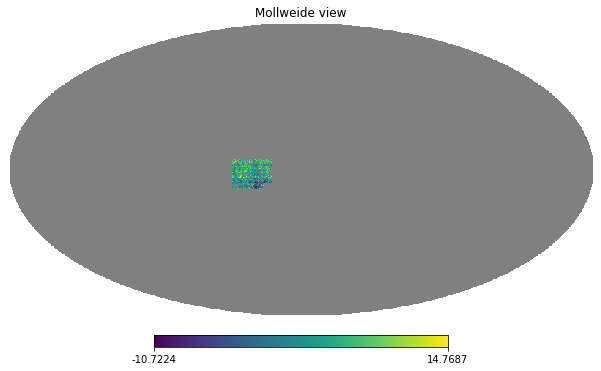

In [10]:
#function for healpy to reduce resolution size of sys
#make a healpix map from the sysMap:
#Healpy method: one array: index is the pixel ID, (length= number of healpix pixels in entire sphere, index = value ID, 
#signal= each value)

index_mask = np.argsort(dmass_val['HPIX_4096'])
dmass_chron = dmass_val[index_mask] # ordered by hpix values

#dim_mask = np.in1d(sysMap['PIXEL'], dmass_chron['HPIX_4096'], assume_unique=False, invert=False)

sysHp = np.full(hp.nside2npix(4096), hp.UNSEEN)
#sysHp[sysMap['PIXEL'][dim_mask]] = sysMap['SIGNAL'][dim_mask]
sysHp[sysMap['PIXEL']] = sysMap['SIGNAL']
#print(sysHp.size)
#print(sysHp[35369:35469])

#print(sysMap['PIXEL'][dim_mask][0])

nside_in = hp.pixelfunc.get_nside(sysHp)
#print(nside_in)
downgrade = hp.pixelfunc.ud_grade(sysHp, 512, pess=False, order_in='RING', order_out=None, power=None, dtype=None)
#downgrade128 = hp.pixelfunc.ud_grade(sysHp, 128, pess=False, order_in='RING', order_out=None, power=None, dtype=None)
#downgrade256 = hp.pixelfunc.ud_grade(sysHp, 256, pess=False, order_in='RING', order_out=None, power=None, dtype=None)

#default order_out = ring, change to nest? -- check
nside_out = hp.pixelfunc.get_nside(downgrade)
#print(nside_out)

n_good_pixels_at_512 = hp.nside2npix(nside_out)
#np.zeros(n_good_pixels_at_512, dtype=[('PIXEL','int'), ('SIGNAL','float')] )
pixels = np.zeros(n_good_pixels_at_512)
#print(pixels.size)

#print(hp.visufunc.mollview(sysHp))

In [11]:
for x in range(pixels.size):
    if x>0:
        pixels[x]=pixels[x-1]+1
#print(pixels)

sysMap = np.zeros( len(pixels), dtype=[('HPIX_512','int'), ('SIGNAL','float'),('RA','float'),('DEC','float')])
sysMap['HPIX_512'] = pixels
sysMap['SIGNAL'] = downgrade

#print(sysMap.size)
#sysMap = keepGoodRegion(sysMap)
#print(sysMap.size)

#restrict to validation region area:
RA, DEC = hp.pix2ang(512, sysMap['HPIX_512'], lonlat=True)
#theta, phi = hp.pix2ang(512, sysMap['PIXEL'])
##sys_area = np.zeros( len(phi), dtype=[('RA','float'), ('DEC','float')] )

# Convert silly ra/dec to silly HP angular coordinates.
##phi = des['RA'] * np.pi / 180.0
#RA = phi*(180.0/np.pi)
#DEC = -(180.0/np.pi)*theta+90.0
##theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

sysMap['RA']= RA
sysMap['DEC'] = DEC

#print(sysMap.size)

#print((sysMap != 0.0 ).any())

3145728
3145728


In [12]:
#all griz combined fracdet map

path = '/fs/scratch/PCON0008/warner785/bwarner/'
fracDet = fitsio.read(path+'y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz')

#print(fracDet.dtype.names)
#print(fracDet['SIGNAL'])

('PIXEL', 'SIGNAL')
[1.      0.875   1.      ... 0.09375 0.8125  0.0625 ]


In [13]:
#convert fracDet to nside 512:

frac = np.zeros(hp.nside2npix(4096))
fracDet["PIXEL"] = hp.nest2ring(4096, fracDet['PIXEL'])
#sysHp[sysMap['PIXEL'][dim_mask]] = sysMap['SIGNAL'][dim_mask]
frac[fracDet['PIXEL']] = fracDet['SIGNAL']

downgrade_frac = hp.pixelfunc.ud_grade(frac, 512, pess=False, order_in='RING', order_out=None, power=None, dtype=None)

In [14]:
n_good_pixels_at_512 = hp.nside2npix(nside_out)
#np.zeros(n_good_pixels_at_512, dtype=[('PIXEL','int'), ('SIGNAL','float')] 
 
pixels = np.arange( n_good_pixels_at_512)


fracDet_512 = np.zeros( len(pixels), dtype=[('HPIX_512','int'), ('SIGNAL','float')])
fracDet_512['HPIX_512'] = pixels
fracDet_512['SIGNAL'] = downgrade_frac

#print(fracDet_512["HPIX_512"].size)
#print(fracDet["PIXEL"].size)

3145728
25169981


In [15]:
from numpy.lib.recfunctions import append_fields

theta, phi = hp.pix2ang(4096, dmass_chron['HPIX_4096'], nest = True)
HPIX_512 = hp.ang2pix(512, theta, phi)

dmass_chron = append_fields(dmass_chron, 'HPIX_512', HPIX_512, usemask=False)
#print(dmass_chron.dtype.names)

('COADD_OBJECT_ID', 'RA', 'DEC', 'HPIX_4096', 'MAG_DETMODEL_G', 'MAGERR_DETMODEL_G', 'MAG_DETMODEL_R', 'MAGERR_DETMODEL_R', 'MAG_DETMODEL_I', 'MAGERR_DETMODEL_I', 'MAG_DETMODEL_Z', 'MAGERR_DETMODEL_Z', 'MOF_CM_MAG_ERR_G', 'MOF_CM_MAG_ERR_R', 'MOF_CM_MAG_ERR_I', 'MOF_CM_MAG_ERR_Z', 'MOF_CM_MAG_CORRECTED_G', 'MOF_CM_MAG_CORRECTED_R', 'MOF_CM_MAG_CORRECTED_I', 'MOF_CM_MAG_CORRECTED_Z', 'SOF_CM_MAG_ERR_G', 'SOF_CM_MAG_ERR_R', 'SOF_CM_MAG_ERR_I', 'SOF_CM_MAG_ERR_Z', 'SOF_CM_MAG_CORRECTED_G', 'SOF_CM_MAG_CORRECTED_R', 'SOF_CM_MAG_CORRECTED_I', 'SOF_CM_MAG_CORRECTED_Z', 'EXTENDED_CLASS_MASH_SOF', 'CMASS_PROB', 'WEIGHT', 'HPIX_512')


min:  -5.299380424779635
max:  10.863681965836138
None


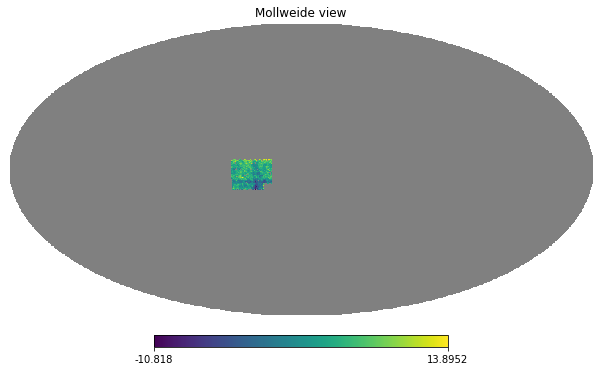

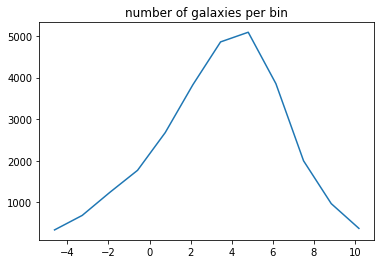

In [16]:
import matplotlib.pyplot as plt

#np.percentile()

#dim_mask = np.in1d(sysMap['HPIX_512'], dmass_chron['HPIX_512'], assume_unique=False, invert=False)
#print(sum(dim_mask), dim_mask.size)

#minimum = np.percentile(sysMap['SIGNAL'][dim_mask], 1)
minimum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 1)
#minimum = np.min(sysMap['SIGNAL'][dim_mask]) #FWHM signal (for g filter)
#maximum = np.percentile(sysMap['SIGNAL'][dim_mask], 99)
maximum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 99)
#maximum = np.max(sysMap['SIGNAL'][dim_mask])
#print("min: ", minimum)
#print("max: ", maximum)

#pbin = np.linspace(-.03, .04, 1000)
pbin, pstep = np.linspace( minimum, maximum, 13, retstep=True)
pcenter = pbin[:-1] + pstep/2

#x = np.zeros(hp.nside2npix(512))
x = np.full(hp.nside2npix(512), hp.UNSEEN)
#print(x, sum(x))
#x[sysMap['PIXEL'][dim_mask]] = sysMap['SIGNAL'][dim_mask]
x[sysMap['HPIX_512']] = sysMap['SIGNAL']

#print(hp.visufunc.mollview(x)) # this is fine
#print(hp.UNSEEN)

#systematic value at galaxy location:

sysval_gal = x[dmass_chron['HPIX_512']].copy()

#which healpixels have values in the sysMap signal

#print(sum(sysval_gal[sysval_gal != hp.UNSEEN]))
#print(hp.UNSEEN)

#print(x.size, sysval_gal.size, dmass_chron.size)
#print(maximum, minimum)
#print((sysval_gal != 0.0).any())
h,_ = np.histogram(sysval_gal[sysval_gal != hp.UNSEEN], bins=pbin, weights = dmass_chron["WEIGHT"][sysval_gal != hp.UNSEEN]) # -- density of dmass sample, not gold sample
#print(h)

# want this plotted:
#h/number_of_pixels_in_sysbin

#fracerr = 1/np.sqrt(h) #1 / sqrt(number of cmass galaxies in each bin)

# change to number density: divide by area
fig, ax = plt.subplots()
ax.errorbar( pcenter, h)
#ax.legend(chi2_reduced)
plt.title('number of galaxies per bin')
fig.savefig('gal_bin.pdf')

#print(hp.visufunc.mollview(sysMap['SIGNAL'][dim_mask]))

[13.21132391 14.21167544 12.63256089 ...  2.25964296  6.48364325
  4.20400508]
27116
area without weights:
[ 258  572 1079 1670 2521 3682 4648 4963 3784 2039  948  408]
[      0       1       2 ... 3145725 3145726 3145727]
[13.21132391 14.21167544 12.63256089 ...  2.25964296  6.48364325
  4.20400508]
27116
sum:  379041.4577636719
area with weights:
[ 250.65429688  556.14770508 1047.19433594 1623.47387695 2458.45239258
 3591.0625     4528.20996094 4828.65307617 3681.36669922 1980.45800781
  915.97314453  390.96850586]
None


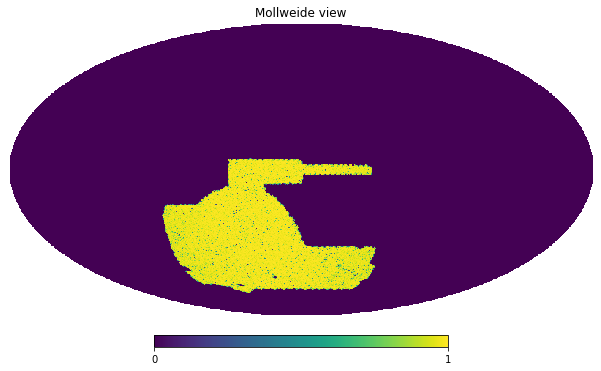

In [17]:
# number of galaxies in each pixel:

sys_signal = sysMap['SIGNAL']

#print(sys_signal[sys_signal != hp.UNSEEN])
#print(sys_signal[sys_signal != hp.UNSEEN].size)

n,_ = np.histogram(sys_signal[sys_signal != hp.UNSEEN] , bins=pbin )
print('area without weights:')
print(n)

#corrected fracDet nside 512 //

#matched_sys2 = sysMap[dim_mask]
sys = sysMap
mask = np.full(hp.nside2npix(512), hp.UNSEEN)

print(fracDet_512["HPIX_512"])

#Only look at pixels where fracDet has value
frac_mask = np.in1d(fracDet_512["HPIX_512"], sys["HPIX_512"], assume_unique=False, invert=False)

#make an array with signals corresponding to pixel values 
mask[sys["HPIX_512"]] = sys["SIGNAL"]

#array only including fracDet/sys seen pixels sys signal values 
#print(mask[mask != hp.UNSEEN])
frac_sys = mask[fracDet_512["HPIX_512"][frac_mask]]

#print(frac_sys[frac_sys != hp.UNSEEN])
#print(frac_sys[frac_sys != hp.UNSEEN].size)

#print(frac_sys[frac_sys != hp.UNSEEN])


#print("sum: ", sum(fracDet_512["SIGNAL"]))

#weights of fracDet in the overlap applied for accurate areas
area,_ = np.histogram(frac_sys[frac_sys != hp.UNSEEN] , bins=pbin , weights = fracDet_512["SIGNAL"][frac_mask][frac_sys != hp.UNSEEN])
print('area with weights:')
print(area)
# area = units of healpixels

#print(hp.visufunc.mollview(fracDet_512["SIGNAL"]))

In [18]:
#print(random_val.dtype.names)

# convert nside for randoms:
phi = random_val['RA'] * np.pi / 180.0
theta = ( 90.0 - random_val['DEC'] ) * np.pi/180.0
nside= 4096

HPIX_512 = hp.ang2pix(512, theta, phi)

random_val = append_fields(random_val, 'HPIX_512', HPIX_512, usemask=False)
#print(random_val.dtype.names)

index_ran_mask = np.argsort(random_val['HPIX_512'])
random_chron = random_val[index_ran_mask] # ordered by hpix values

('RA', 'DEC', 'WEIGHT')


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/healpy/pixelfunc.py:481: RuntimeWarning: invalid value encountered in _ang2pix_ring
  return pixlib._ang2pix_ring(nside, theta, phi)


('RA', 'DEC', 'WEIGHT', 'HPIX_512')


None
number of random galaxies:  [ 196.  467.  872. 1337. 1987. 3083. 3774. 4089. 2923. 1503.  701.  284.]
randoms number density:  [0.7819534811236217, 0.8397049843699311, 0.83270121893788, 0.8235426630388606, 0.8082320430522052, 0.8585202847346711, 0.8334419191151304, 0.8468200004216772, 0.7939985985694692, 0.7589153590083575, 0.7653062801952969, 0.7264012209263478]
total_area:  25852.614501953125
total galaxies:  21216.0
total number density:  0.82065200788095
[0.95284417 1.02321688 1.01468249 1.00352239 0.98486574 1.04614413
 1.01558506 1.03188683 0.96752167 0.92477122 0.93255883 0.88515134]
normalized error:  [0.0680603  0.04734883 0.03436148 0.02744488 0.02209419 0.01884104
 0.01653162 0.01613703 0.0178956  0.02385365 0.03522226 0.05252407]


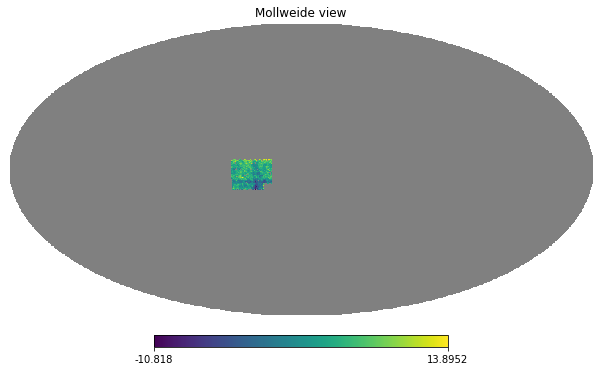

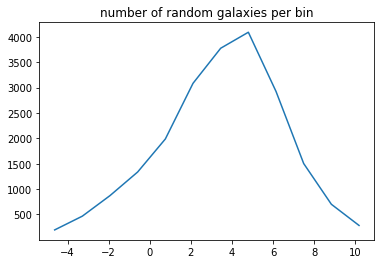

In [19]:
# now for randoms:

import matplotlib.pyplot as plt

#dim_ran_mask = np.in1d(sysMap['PIXEL'], random_chron, assume_unique=False, invert=False)

#minimum = np.percentile(sysMap['SIGNAL'][dim_mask], 1)
minimum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 1)
#minimum = np.min(sysMap['SIGNAL'][dim_mask]) #FWHM signal (for g filter)
#maximum = np.percentile(sysMap['SIGNAL'][dim_mask], 99)
maximum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 99)
#print(minimum)
#print(maximum)

pbin, pstep = np.linspace( minimum, maximum, 13, retstep=True)
pcenter = pbin[:-1] + pstep/2

#x = np.zeros(hp.nside2npix(512))
x = np.full(hp.nside2npix(512), hp.UNSEEN)
#print(x, sum(x))
#x[sysMap['PIXEL'][dim_mask]] = sysMap['SIGNAL'][dim_mask]
x[sysMap['HPIX_512']] = sysMap['SIGNAL']

print(hp.visufunc.mollview(x)) # this is fine
#print(hp.UNSEEN)

#systematic value at galaxy location:

sysval_gal_ran = x[random_chron['HPIX_512']].copy()

#which healpixels have values in the sysMap signal

#print(sum(sysval_gal[sysval_gal != hp.UNSEEN]))
#print(hp.UNSEEN)

#print(x.size, sysval_gal.size, dmass_chron.size)
#print(maximum, minimum)
#print((sysval_gal != 0.0).any())
h_ran,_ = np.histogram(sysval_gal_ran[sysval_gal_ran != hp.UNSEEN], bins=pbin, weights = random_chron["WEIGHT"][sysval_gal_ran != hp.UNSEEN]) # -- density of dmass sample, not gold sample
#print(h)

# want this plotted:
#h/number_of_pixels_in_sysbin

#fracerr = 1/np.sqrt(h) #1 / sqrt(number of cmass galaxies in each bin)

# change to number density: divide by area
fig, ax = plt.subplots()
ax.errorbar( pcenter, h_ran)
#ax.legend(chi2_reduced)
plt.title('number of random galaxies per bin')
fig.savefig('ran_gal_bin.pdf')

#print(hp.visufunc.mollview(sysMap['SIGNAL'][dim_mask]))

# h_ran = number of galaxies
#print("number of random galaxies: ", h_ran)

# number density in bins: h/area
number_density_ran = []
for x in range(len(h_ran)):
    den_ran = h_ran[x]/area[x]
    number_density_ran.append(den_ran)
    
#print("randoms number density: ", number_density_ran)


total_area = 0
#Normalize based on total number density of used footprint:
for x in range(len(area)):
    total_area += area[x]

#print("total_area: ", total_area)

# total galaxies:
total_h_ran = 0
for x in range(len(h_ran)):
    total_h_ran += h_ran[x]

#print("total galaxies: ", total_h_ran)

#normalization: 
total_num_density_ran = total_h_ran/total_area

#print("total number density: ", total_num_density_ran)

# apply normalization: 
#print(number_density)
norm_number_density_ran = number_density_ran/total_num_density_ran
#print(norm_number_density_ran)

fracerr_ran = np.sqrt(h_ran) #1 / sqrt(number of randoms cmass galaxies in each bin)
fracerr_ran_norm = (fracerr_ran/area)/total_num_density_ran
#print("normalized error: ", fracerr_ran_norm)

Text(0.5, 1.0, 'number of randoms versus dmass per bin')

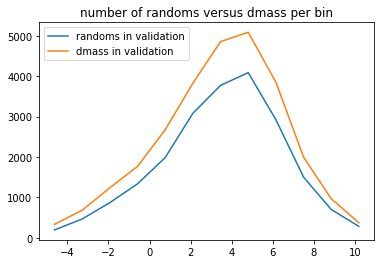

In [20]:
fig, ax = plt.subplots()
ax.errorbar( pcenter, h_ran, label = "randoms in validation")
ax.errorbar( pcenter, h, label = "dmass in validation")
plt.legend()
#ax.legend(chi2_reduced)
plt.title('number of randoms versus dmass per bin')

dmass number density:  [1.3386676545972798, 1.23041862385474, 1.1837661334963265, 1.0895747483990232, 1.0882428878393926, 1.065704753091775, 1.072433395187311, 1.0538849836328532, 1.046426198338736, 1.0082332502224536, 1.056328333785986, 0.9516617492885314]
total_area:  25852.614501953125
total galaxies:  27664.501213292442
normalized error:  [0.06829367 0.04395548 0.03141962 0.02420959 0.01966136 0.01609862
 0.01438148 0.01380592 0.01575547 0.02108528 0.03173509 0.04610543]
total number density:  1.0700852407481816
[1.25099161 1.14983235 1.10623536 1.01821304 1.01696841 0.99590641
 1.00219436 0.98486078 0.97789051 0.94219901 0.9871441  0.88933266]


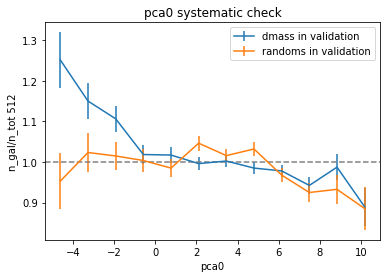

In [21]:
# *****Creating the figure******:

#Also, we usually normalize the plots to the total number density of the total footprint considered. 
#so that we expect the final result to be a flat line at y=1.

# number density in bins: h/area
number_density = []
for x in range(len(h)):
    den = h[x]/area[x]
    number_density.append(den)
    
#print("dmass number density: ", number_density)

total_area = 0
#Normalize based on total number density of used footprint:
for x in range(len(area)):
    total_area += area[x]

#print("total_area: ", total_area)

# total galaxies:
total_h = 0
for x in range(len(h)):
    total_h += h[x]

#print("total galaxies: ", total_h)

#normalization: 
total_num_density = total_h/total_area


#errorbars: (how to define these)
fracerr = np.sqrt(h)
fracerr_norm = (fracerr/area)/total_num_density
#print("normalized error: ", fracerr_norm)


#print("total number density: ", total_num_density)

# apply normalization: 
#print(number_density)
norm_number_density = number_density/total_num_density
print(norm_number_density)

import matplotlib.pyplot as plt
#figure of systematics:

fracerr = 1/np.sqrt(h) #1 / sqrt(number of cmass galaxies in each bin)

# change to number density: divide by area
fig, ax = plt.subplots()
ax.errorbar( pcenter, norm_number_density, yerr=fracerr_norm, label = "dmass in validation")
ax.errorbar( pcenter, norm_number_density_ran, yerr=fracerr_ran_norm, label = "randoms in validation")
plt.legend()
plt.xlabel("pca0")
plt.ylabel("n_gal/n_tot 512")
#plt.ylim(top=1.2)  # adjust the top leaving bottom unchanged
#plt.ylim(bottom=0.85)
plt.axhline(y=1, color='grey', linestyle='--')
plt.title('pca0 systematic check')
fig.savefig('pca0.pdf')

In [ ]:
#chi**2 values for qualitative analysis:
# difference of (randoms-horizontal line)**2/err_ran**2
x1_ran = norm_number_density_ran
x2_ran = 1
err_ran = fracerr_ran_norm
chi2_ran = (x1_ran-x2_ran)**2 / err_ran **2 
chi2_ran_reduced = sum(chi2_ran)/chi2_ran.size
print("chi2_ran: ",chi2_ran_reduced)

In [ ]:
# fit to trend:

fig,ax = plt.subplots(1,1)
#linear trends first -- chi2 for higher order study --- check for threshold value (afterward)
z = np.polyfit(pcenter, norm_number_density, 1)
p = np.poly1d(z)

print(p)
print(p(pcenter))
print(pcenter)

ax.plot(pcenter,p(pcenter),"r--")
ax.errorbar( pcenter, norm_number_density, yerr=fracerr_norm, label = "dmass in validation")

#plt.ylim(top=1.4)  # adjust the top leaving bottom unchanged
#plt.ylim(bottom=0.8)
#plt.xlim(right=10) 
#plt.xlim(left=-4)

plt.title('pca0 systematic trendline')
fig.savefig('pca0_trend.pdf')

# chi2 of dmass versus trend line
#difference of (dmass - correction line)**2/err**2

x1 = norm_number_density
x2 = p(pcenter)
err = fracerr_norm
chi2 = (x1-x2)**2 / err **2 
chi2_reduced = sum(chi2)/chi2.size
print("chi2: ",chi2_reduced)

In [ ]:
# difference of (dmasslineaer correction - line)**2/err**2